In [1]:
from dataclasses import dataclass
from IPython.core.display import HTML
import plotly
import plotly.graph_objects as go
import noise
from numpy.lib.stride_tricks import as_strided
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import axes3d
import plotly
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# taken from https://jackmckew.dev/3d-terrain-in-python.html#3d-terrain-in-python
shape = (50, 50)
scale = 100.0
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(
            i/scale, 
            j/scale, 
            octaves=octaves, 
            persistence=persistence, 
            lacunarity=lacunarity, 
            repeatx=1024, 
            repeaty=1024, 
            base=42
        )

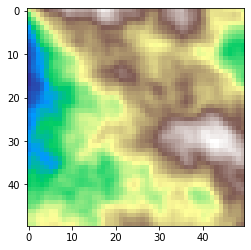

In [3]:
matplotlib.pyplot.imshow(world,cmap='terrain')

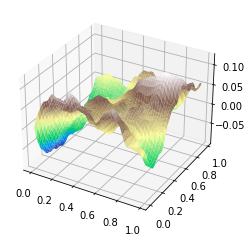

In [4]:
lin_x = np.linspace(0,1,shape[0],endpoint=False)
lin_y = np.linspace(0,1,shape[1],endpoint=False)
x,y = np.meshgrid(lin_x,lin_y)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,world,cmap='terrain')

In [9]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0 / (pl_entries - 1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k * h)[:3]) * 255))
        pl_colorscale.append([k * h, 'rgb' + str((C[0], C[1], C[2]))])

    return pl_colorscale


terrain_cmap = matplotlib.cm.get_cmap('terrain')
terrain = matplotlib_to_plotly(terrain_cmap, 255)

In [10]:
def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)

def cell_neighbours(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)

    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)

    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)

    return w[ix, jx][i0:i1,j0:j1].ravel()


@dataclass
class descent_step:
    """Class for storing each step taken in gradient descent"""
    value: float
    x_index: float
    y_index: float


def gradient_descent_3d(array, x_start, y_start, steps=50, step_size=1, plot=False):
    # Initial point to start gradient descent at
    step = descent_step(array[y_start][x_start], x_start, y_start)

    # Store each step taken in gradient descent in a list
    step_history = []
    step_history.append(step)

    # Plot 2D representation of array with startng point as a red marker
    if plot:
        matplotlib.pyplot.imshow(array, origin='lower', cmap='terrain')
        matplotlib.pyplot.plot(x_start, y_start, 'ro')
    current_x = x_start
    current_y = y_start

    # Loop through specified number of steps of gradient descent to take
    for i in range(steps):
        prev_x = current_x
        prev_y = current_y

        # Extract array of neighbouring cells around current step location with size nominated
        neighbours = cell_neighbours(array, current_y, current_x, step_size)

        # Locate minimum in array (steepest slope from current point)
        next_step = neighbours.min()
        indices = np.where(array == next_step)

        # Update current point to now be the next point after stepping
        current_x, current_y = (indices[1][0], indices[0][0])
        step = descent_step(array[current_y][current_x], current_x, current_y)

        step_history.append(step)

        # Plot each step taken as a black line to the current point nominated by a red marker
        if plot:
            matplotlib.pyplot.plot([prev_x, current_x], [prev_y, current_y], 'k-')
            matplotlib.pyplot.plot(current_x, current_y, 'ro')

        # If step is to the same location as previously, this infers convergence and end loop
        if prev_y == current_y and prev_x == current_x:
            print(f"Converged in {i} steps")
            break
    return next_step, step_history



# Source https://stackoverflow.com/questions/51272288/how-to-calculate-the-vector-from-two-points-in-3d-with-python
def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
   deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
   runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
   for coOrd in deltaVals:
       runningSquared += coOrd**2
   return runningSquared**(1/2)

def findVec(point1,point2,unitSphere = False):
  #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
  finalVector = [0 for coOrd in point1]
  for dimension, coOrd in enumerate(point1):
      #finding total differnce for that co-ordinate(x,y,z...)
      deltaCoOrd = point2[dimension]-coOrd
      #adding total difference
      finalVector[dimension] = deltaCoOrd
  if unitSphere:
      totalDist = multiDimenDist(point1,point2)
      unitVector =[]
      for dimen in finalVector:
          unitVector.append( dimen/totalDist)
      return unitVector
  else:
      return finalVector

In [11]:
def generate_3d_plot(step_history):
    # Initialise empty lists for markers
    step_markers_x = []
    step_markers_y = []
    step_markers_z = []
    step_markers_u = []
    step_markers_v = []
    step_markers_w = []

    for index, step in enumerate(step_history):
        step_markers_x.append(step.x_index)
        step_markers_y.append(step.y_index)
        step_markers_z.append(step.value)

        # If we haven't reached the final step, calculate the vector between the current step and the next step
        if index < len(steps) - 1:
            vec1 = [step.x_index, step.y_index, step.value]
            vec2 = [steps[index + 1].x_index, steps[index + 1].y_index, steps[index + 1].value]

            result_vector = findVec(vec1, vec2)
            step_markers_u.append(result_vector[0])
            step_markers_v.append(result_vector[1])
            step_markers_w.append(result_vector[2])
        else:
            step_markers_u.append(0.1)
            step_markers_v.append(0.1)
            step_markers_w.append(0.1)

    return step_markers_x, step_markers_y, step_markers_z, step_markers_u, step_markers_v, step_markers_w

def create_fig_data(step_markers_x, step_markers_y, step_markers_z, step_markers_u, step_markers_v, step_markers_w):
    data=[
        go.Cone(
            x=step_markers_x,
            y=step_markers_y,
            z=step_markers_z,
            u=step_markers_u,
            v=step_markers_v,
            w=step_markers_w,
            sizemode="absolute",
            sizeref=2,
            anchor='tail'),

        go.Scatter3d(
            x=step_markers_x,
            y=step_markers_y,
            z=step_markers_z,
            mode='lines',
            line=dict(
                color='red',
                width=2
            )),

        go.Surface(colorscale=terrain, z=world, opacity=0.5)]

    return data


def figure_3d(data: list):
    # Include cones at each marker to show direction of step, scatter3d is to show the red line between points and surface for the terrain
    fig = go.Figure(data=data)

    # Z axis is limited to the extent of the terrain array
    fig.update_layout(
        title='Gradient Descent Steps',
        scene=dict(zaxis=dict(range=[world.min(), world.max()], ), ), )
    return fig


def find_minimum_and_steps(seed):
    np.random.seed(seed)
    z = world
    global_minimum = z.min()
    indices = np.where(z == global_minimum)
    print(f"Target: {global_minimum} @ {indices}")

    step_size = 0
    found_minimum = 99999

    # Random starting point
    start_x = np.random.randint(0, 50)
    start_y = np.random.randint(0, 50)

    # Increase step size until convergence on global minimum
    while found_minimum != global_minimum:
        step_size += 1
        found_minimum, steps = gradient_descent_3d(z, start_x, start_y, step_size=step_size, plot=False)

    print(f"Optimal step size {step_size}")
    found_minimum, steps = gradient_descent_3d(z, start_x, start_y, step_size=step_size, plot=True)
    print(f"Steps: {steps}")
    return steps

Target: -0.0994970053434372 @ (array([16]), array([0]))
Converged in 9 steps
Converged in 5 steps
Converged in 7 steps
Converged in 6 steps
Converged in 4 steps
Converged in 4 steps
Converged in 3 steps
Converged in 3 steps
Converged in 3 steps
Converged in 5 steps
Optimal step size 10
Converged in 5 steps
Steps: [descent_step(value=0.10347005724906921, x_index=38, y_index=28), descent_step(value=0.007558110170066357, x_index=28, y_index=38), descent_step(value=-0.03461135923862457, x_index=18, y_index=39), descent_step(value=-0.03682023286819458, x_index=8, y_index=35), descent_step(value=-0.07587684690952301, x_index=0, y_index=26), descent_step(value=-0.0994970053434372, x_index=0, y_index=16), descent_step(value=-0.0994970053434372, x_index=0, y_index=16)]
Target: -0.0994970053434372 @ (array([16]), array([0]))
Converged in 5 steps
Converged in 3 steps
Converged in 3 steps
Converged in 2 steps
Converged in 2 steps
Converged in 2 steps
Converged in 2 steps
Converged in 6 steps
Optim

'temp-plot.html'

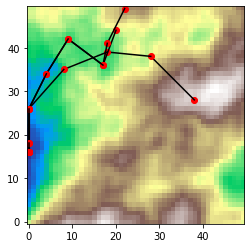

In [20]:
all_trajectories = []
for seed in [42, 111, 9999]:
    steps = find_minimum_and_steps(seed)
    all_trajectories.append(steps)

data = []
for i, steps in enumerate(all_trajectories):
    step_markers_x, step_markers_y, step_markers_z, step_markers_u, step_markers_v, step_markers_w = generate_3d_plot(steps)
    data_trajectory = create_fig_data(step_markers_x, step_markers_y, step_markers_z, step_markers_u, step_markers_v,
                            step_markers_w)
    data += data_trajectory

print(data)
fig = figure_3d(data)
plotly.offline.plot(fig)
# HTML(plotly.offline.plot(fig, filename='random_starting_point_3d_gradient_descent.html', include_plotlyjs='cdn'))

[]("https://imgur.com/BkPB6MD")